In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
#import pickle
import cv2
import os
import pandas as pd
from PIL import Image
#import imutils

In [2]:
Adata = pd.read_csv("lib/datasets/LISA/allAnnotations.csv", delimiter=';')
Adata

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,"Occluded,On another road",Origin file,Origin frame number,Origin track,Origin track frame number
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
2,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,922,88,982,148,"1,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
3,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,447,193,461,210,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
4,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,469,189,483,207,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2677,stop_1330545910.avi,12
...,...,...,...,...,...,...,...,...,...,...,...
7850,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,41,209,65,239,"0,0",vid9/MVI_0121.MOV,8813,speedLimit_1324866802.avi,22
7851,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,526,213,543,233,"0,0",vid9/MVI_0121.MOV,8875,speedLimit_1324866807.avi,2
7852,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,546,208,564,230,"0,0",vid9/MVI_0121.MOV,8880,speedLimit_1324866807.avi,7
7853,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,573,204,592,228,"0,0",vid9/MVI_0121.MOV,8885,speedLimit_1324866807.avi,12


In [5]:
#max image size
height = 227
width = 227
data = []
labels = []
bboxes =[]
imagePaths=[]
path = "lib/datasets/LISA/"
test = 0
import random
sub_sample = random.sample(list(range(len(Adata["Filename"]))),k = len(Adata["Filename"]) - 1000)
for i in range(len(Adata["Filename"])):
    file = Adata["Filename"][i]
    sign = Adata["Annotation tag"][i]
    image = Image.open(path+file)
    h, w = image.height,image.width
    image = image.resize((width,height))
    image = np.asarray(image)
    data.append(image)
    labels.append(sign)
    bboxes.append((float(Adata['Upper left corner X'][i])/w,float(Adata['Upper left corner Y'][i])/h,float(Adata['Lower right corner X'][i])/w,float(Adata['Lower right corner Y'][i])/h))

In [6]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [7]:
split = train_test_split(data, labels, bboxes,test_size=0.20)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]

In [13]:
vgg = VGG16(include_top=False,input_tensor=Input(shape=(227, 227, 3)))
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

In [18]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input,outputs=(bboxHead, softmaxHead))

In [15]:
losses = {"class_label": "categorical_crossentropy","bounding_box": "mean_squared_error",}
lossWeights = {"class_label": 1.0,"bounding_box": 1.0
}
opt = 'Adam'
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)

In [16]:
trainTargets = {"class_label": trainLabels,"bounding_box": trainBBoxes
}
testTargets = {"class_label": testLabels,"bounding_box": testBBoxes
}

In [17]:
H = model.fit(trainImages, trainTargets,validation_data=(testImages, testTargets),batch_size=64,epochs=30,verbose=1)

Epoch 1/30
99/99 [==============================] - ETA: 0s - loss: 3.0306 - bounding_box_loss: 0.0239 - class_label_loss: 3.0067 - bounding_box_accuracy: 0.6254 - class_label_accuracy: 0.2387

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/block1_conv2/Conv2D' defined at (most recent call last):
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\dokee\AppData\Local\Temp/ipykernel_30716/598510904.py", line 1, in <module>
      H = model.fit(trainImages, trainTargets,validation_data=(testImages, testTargets),batch_size=64,epochs=30,verbose=1)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1431, in fit
      _use_cached_eval_dataset=True)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1716, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1525, in test_function
      return step_function(self, iterator)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1514, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1507, in run_step
      outputs = model.test_step(data)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1471, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\engine\functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\dokee\anaconda3\envs\tensor\lib\site-packages\keras\layers\convolutional.py", line 240, in convolution_op
      name=self.__class__.__name__)
Node: 'model_1/block1_conv2/Conv2D'
OOM when allocating tensor with shape[64,64,227,227] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/block1_conv2/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_3895]

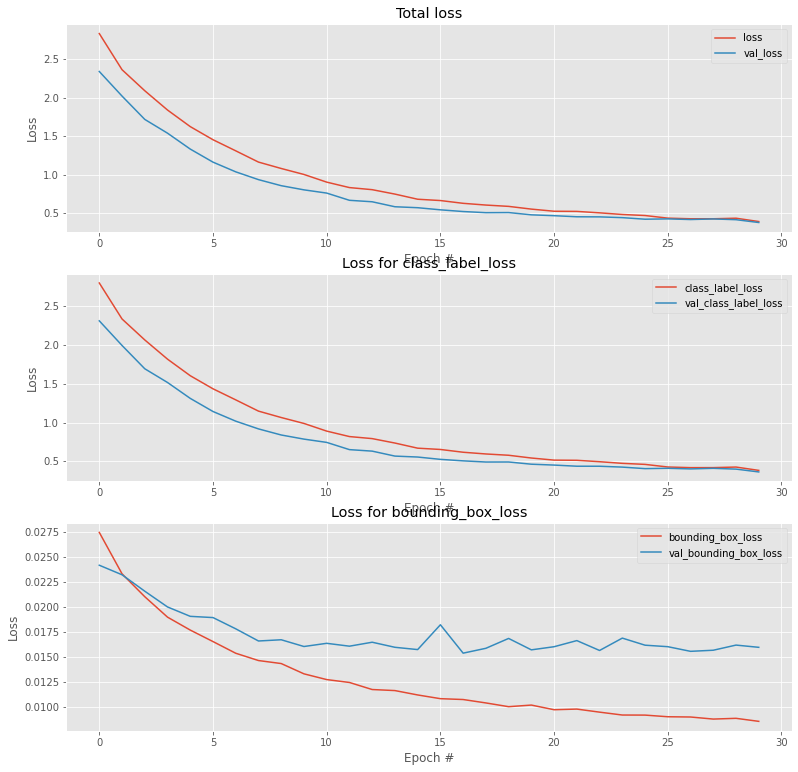

In [12]:
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0,30)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()

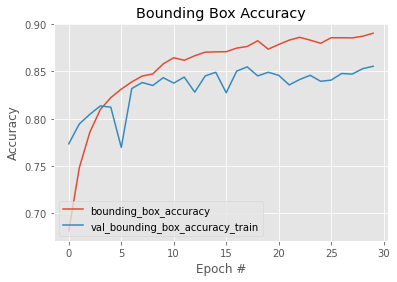

In [13]:
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
	label="bounding_box_accuracy")
plt.plot(N, H.history["val_bounding_box_accuracy"],
	label="val_bounding_box_accuracy_train")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

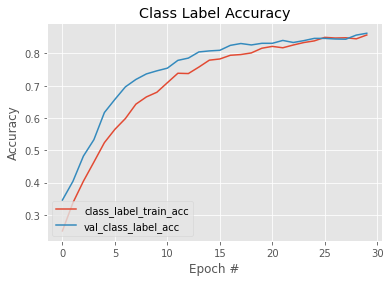

In [14]:
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [15]:
model.save('model.h5')

In [16]:
model=load_model('model.h5')

In [17]:
import cv2 as cv

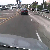

In [18]:
x=load_img('testout.jpg',target_size=(50,50))
x

In [19]:
x=img_to_array(x)/255.0
x=np.expand_dims(x,axis=0)

In [20]:
preds,labels=model.predict(x)

In [21]:
preds

array([[0.848667  , 0.12188482, 0.8958434 , 0.19704697]], dtype=float32)

In [22]:
x1,y1,x2,y2=preds[0]

image = cv.imread('sample.jpg')
#image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
startX = int(x1* w)
startY = int(y1 * h)
endX = int(x2* w)
endY = int(y2 * h)
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
cv2.imshow("Output", image)
cv2.waitKey(0)

In [23]:
list(labels[0]).index(max(labels[0])),max(labels[0])

(35, 0.44803718)

In [24]:
labels[0]

array([4.1246942e-05, 7.2835695e-07, 5.3302138e-08, 6.1187282e-05,
       2.6179612e-06, 2.3823114e-07, 6.7870616e-08, 5.2661218e-02,
       9.4958114e-06, 4.6980050e-03, 5.8835436e-04, 3.3617884e-04,
       2.6551221e-04, 1.9790084e-05, 1.4392457e-07, 1.5319806e-08,
       2.0628396e-07, 1.4289404e-05, 9.1608046e-05, 2.0705362e-05,
       5.7686673e-05, 8.7101316e-06, 2.1411358e-06, 3.1742878e-02,
       1.9593480e-07, 1.2111857e-10, 5.6455255e-02, 8.5029228e-07,
       2.1503719e-07, 4.2240445e-06, 7.8989781e-02, 9.0712728e-04,
       8.3996230e-05, 3.5321180e-05, 1.9106992e-01, 4.4803718e-01,
       1.4868673e-04, 7.5326723e-10, 2.1577878e-07, 1.0419807e-06,
       1.1281744e-06, 1.2177824e-07, 1.3237877e-07, 1.3362162e-01,
       1.9240566e-05, 1.3785998e-07, 6.0349748e-07], dtype=float32)

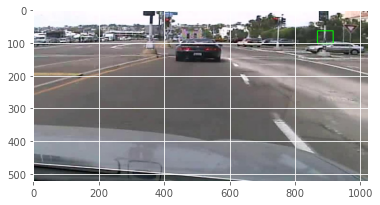

In [25]:
image = cv2.imread('testout.jpg')
#image = imutils.resize(image, width=700)
(h,w) = image.shape[:2]

startX = int(x1 * w)
startY = int(y1 * h)
endX = int(x2* w)
endY = int(y2* h)
# draw the predicted bounding box on the image
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
# show the output image
plt.imshow(image[:,:,::-1])

In [26]:
preds

array([[0.848667  , 0.12188482, 0.8958434 , 0.19704697]], dtype=float32)

In [27]:
image.shape[:2]

(522, 1024)

In [32]:
import cv2
import numpy as np
import time
model=load_model('model.h5')
keys=pd.read_csv('lib/datasets/key.csv')
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

# Read until video is completed
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret == True:
    w,h=frame.shape[:2]
    image = cv2.resize(frame, (50, 50), interpolation = cv2.INTER_LINEAR)
    image=img_to_array(image)/255.0
    image=np.expand_dims(image,axis=0)
    preds,labels=model.predict(image)
    x1,y1,x2,y2=preds[0]
    clas,acc=list(labels[0]).index(max(labels[0])),max(labels[0])
    startX = int(x1 * w)
    startY = int(y1 * h)
    endX = int(x2* w)
    endY = int(y2* h)
    cv2.putText(frame, "Class : "+' '+keys['Label'][clas] +" "+ str(acc*100), (7, 70), font, 1, (100, 255, 0), 1, cv2.LINE_AA)
    cv2.rectangle(frame, (startX, startY), (endX, endY),(0, 255, 0), 2)
    cv2.imshow('Frame',frame)

    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break

  # Break the loop
  else: 
    break

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
keys['Label'][35]